In [2]:
import logging

logging.basicConfig(format='\033[93m%(asctime)s %(levelname)s %(name)s:\033[0m %(message)s', level=logging.INFO, datefmt='%I:%M:%S')
import warnings
import pandas as pd

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action="ignore", category=pd.errors.SettingWithCopyWarning)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

In [4]:
from NNTrade.source.market.quotes import QuoteSource, date
from NNTrade.source.market.client import QuoteSourceClientFinamCSV, TimeFrame
from NNTrade.source.market.cache.filecache.file_cache_quote import FileCacheQuote
from NNTrade.common.candle_col_name import INDEX, OPEN, HIGH, LOW, CLOSE, VOLUME

In [5]:
qsc = QuoteSourceClientFinamCSV("./quote/")
qsc.add_file("EURUSD.Minute1.csv","EURUSD", TimeFrame.m1)
fcq = FileCacheQuote("./cache/quote")
qs = QuoteSource(fcq, qsc)

09:27:10 INFO QuoteSourceClientCSV: File ./quote/EURUSD.Minute1.csv to stock EURUSD timeframe Minute1 added to client


In [6]:
quote_h1_m1 = qs.get("EURUSD",TimeFrame.H, from_date=date(2010,1,1), untill_date=date(2011,1,1), step_timeframe=TimeFrame.m1)
quote_h1_m1

,aggregated_start_date_time,open,low,high,close,volume,isLast
start_date_time,,,,,,,
2010-01-01 00:00:00,2010-01-01 00:00:00,1.4331,1.4327,1.4337,1.4332,0.0,0
2010-01-01 00:01:00,2010-01-01 00:00:00,1.4331,1.4327,1.4337,1.4331,0.0,0
2010-01-01 00:02:00,2010-01-01 00:00:00,1.4331,1.4327,1.4337,1.4329,0.0,0
2010-01-01 00:03:00,2010-01-01 00:00:00,1.4331,1.4327,1.4337,1.4331,0.0,0
2010-01-01 00:04:00,2010-01-01 00:00:00,1.4331,1.4327,1.4337,1.4332,0.0,0
...,...,...,...,...,...,...,...
2010-09-30 23:56:00,2010-09-30 23:00:00,1.3654,1.3571,1.3654,1.3602,0.0,0
2010-09-30 23:57:00,2010-09-30 23:00:00,1.3654,1.3571,1.3654,1.3601,0.0,0
2010-09-30 23:58:00,2010-09-30 23:00:00,1.3654,1.3571,1.3654,1.3595,0.0,0


In [7]:
quote_h1 = quote_h1_m1[quote_h1_m1["isLast"] == 1]
quote_h1.set_index("aggregated_start_date_time",inplace=True)
quote_h1.index.name = INDEX
quote_h1 = quote_h1[[OPEN, HIGH, LOW,CLOSE, VOLUME]]
quote_h1

,open,high,low,close,volume
start_date_time,,,,,
2010-01-01 00:00:00,1.4331,1.4341,1.4319,1.4326,0.0
2010-01-01 01:00:00,1.4325,1.4331,1.4322,1.4324,0.0
2010-01-01 02:00:00,1.4323,1.4325,1.4311,1.4312,0.0
2010-01-01 03:00:00,1.4314,1.4329,1.4310,1.4322,0.0
2010-01-01 04:00:00,1.4341,1.4341,1.4320,1.4329,0.0
...,...,...,...,...,...
2010-09-30 20:00:00,1.3627,1.3683,1.3623,1.3676,0.0
2010-09-30 21:00:00,1.3676,1.3677,1.3616,1.3630,0.0
2010-09-30 22:00:00,1.3630,1.3660,1.3623,1.3653,0.0


# Get Extrem of X candle

In [8]:
from enum import Enum
class ExtreamType(Enum):
  High = 1,
  Low = 2

In [26]:
def get_extrem_of(quote_df:pd.DataFrame, period:int, extrem_type:ExtreamType)->pd.Series:
  if extrem_type == ExtreamType.High:
    col = HIGH
    result_name = f"Max_of_{extrem_type.name}"    
  elif extrem_type == ExtreamType.Low:
    col = LOW
    result_name = f"Min_of_{extrem_type.name}"
  else:
    raise AttributeError("Wrong attribute value", "extrem_type", extrem_type)
  prepare_df = pd.DataFrame([quote_df[col].shift(-shift).rename(f"{col}_{shift}") for shift in range(period+1)]).T
  return (prepare_df.max(axis=1) if extrem_type == ExtreamType.High else prepare_df.min(axis=1)).rename(result_name)

In [27]:
extr_df = get_extrem_of(quote_h1, 2, ExtreamType.Low)
extr_df

start_date_time
2010-01-01 00:00:00    1.4311
2010-01-01 01:00:00    1.4310
2010-01-01 02:00:00    1.4310
2010-01-01 03:00:00    1.4310
2010-01-01 04:00:00    1.4320
                        ...  
2010-09-30 20:00:00    1.3616
2010-09-30 21:00:00    1.3571
2010-09-30 22:00:00    1.3571
2010-09-30 23:00:00    1.3571
2010-10-01 00:00:00    1.3595
Name: Min_of_Low, Length: 4860, dtype: float64

In [28]:
def get_extrem_rel_of(quote_df:pd.DataFrame, period:int, extrem_type:ExtreamType)->pd.Series:
  extrem_sr = get_extrem_of(quote_df, period, extrem_type)
  return ((extrem_sr - quote_h1[OPEN]) / quote_h1[OPEN]).rename(f"Rel_of_{extrem_type.name}")

In [30]:
pd.DataFrame([quote_h1[OPEN], extr_df, extr_df - quote_h1[OPEN], get_extrem_rel_of(quote_h1, 2, ExtreamType.High) ]).T

,open,Min_of_Low,Unnamed 0,Rel_of_High
start_date_time,,,,
2010-01-01 00:00:00,1.4331,1.4311,-0.0020,0.000698
2010-01-01 01:00:00,1.4325,1.4310,-0.0015,0.000419
2010-01-01 02:00:00,1.4323,1.4310,-0.0013,0.001257
2010-01-01 03:00:00,1.4314,1.4310,-0.0004,0.001886
2010-01-01 04:00:00,1.4341,1.4320,-0.0021,0.000000
...,...,...,...,...
2010-09-30 20:00:00,1.3627,1.3616,-0.0011,0.004109
2010-09-30 21:00:00,1.3676,1.3571,-0.0105,0.000073
2010-09-30 22:00:00,1.3630,1.3571,-0.0059,0.002201


In [39]:
X = 2
pd.DataFrame([quote_h1[HIGH].shift(-shift).rename(f"{HIGH}_{shift}") for shift in range(X+1)]).T.max(axis=1)

start_date_time
2010-01-01 00:00:00    1.4341
2010-01-01 01:00:00    1.4331
2010-01-01 02:00:00    1.4341
2010-01-01 03:00:00    1.4341
2010-01-01 04:00:00    1.4341
                        ...  
2010-09-30 20:00:00    1.3683
2010-09-30 21:00:00    1.3677
2010-09-30 22:00:00    1.3660
2010-09-30 23:00:00    1.3654
2010-10-01 00:00:00    1.3603
Length: 4860, dtype: float64

# Create test data 
x_sr - test data series

In [13]:
np.random.seed(1997)

In [14]:
X = np.cumprod(1 + np.random.randn(300) * 0.01)

In [15]:
from datetime import date
from datetime import timedelta 
start_date = date(2000,1,1)
start_date.weekday
x_dt_idx = []
for i in range(300):
    x_dt_idx.append(start_date)
    start_date = start_date+timedelta(days=1)
    while start_date.weekday() >= 5:
        start_date = start_date+timedelta(days=1)

In [16]:
x_sr = pd.Series(X,index=x_dt_idx)
increaser = 1
def increase(x):
    global increaser
    increaser = increaser+0.005
    return x*increaser
x_sr = x_sr.apply(lambda x: increase(x))
x_sr

2000-01-01    1.009469
2000-01-03    1.014741
2000-01-04    1.019599
2000-01-05    1.026967
2000-01-06    1.044660
                ...   
2001-02-16    2.441832
2001-02-19    2.494932
2001-02-20    2.509605
2001-02-21    2.534710
2001-02-22    2.570228
Length: 300, dtype: float64

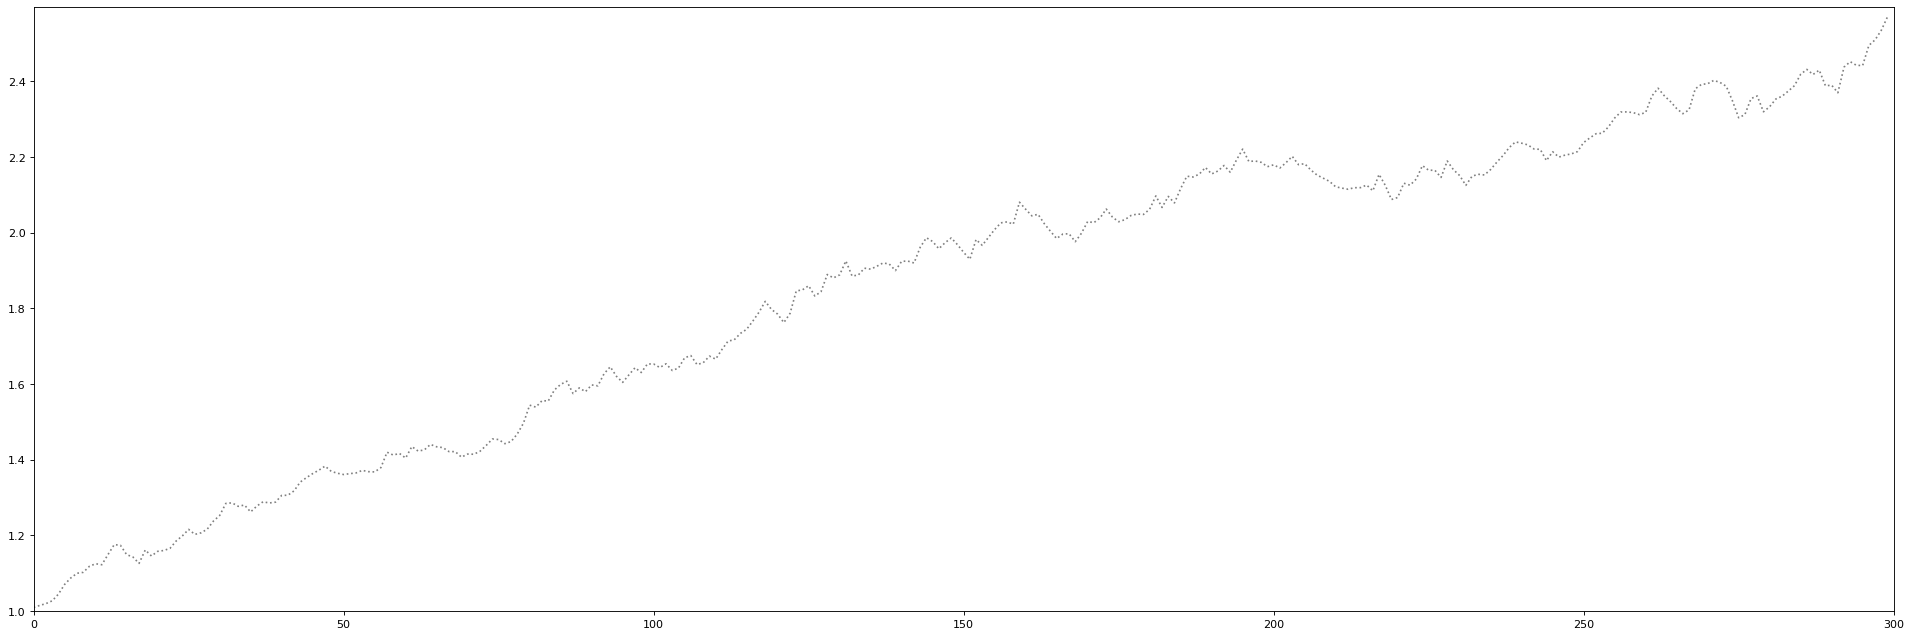

In [21]:
f, ax = plt.subplots(figsize=(30,10), dpi=80)
plt.subplots_adjust(hspace=0)

ax.set_xlim(0, len(X))
ax.set_ylim(x_sr.min()*0.99, x_sr.max()*1.01)
ax.plot(np.arange(len(x_sr)), x_sr, 'k:', alpha=0.5)